In [11]:
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn

from torch.optim import Adam,lr_scheduler


### Read data from datalake

In [2]:
!pip3 install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 118.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

In [3]:
!pip install --upgrade urllib3

In [4]:
import deeplake
train_data = deeplake.load("hub://activeloop/gtsrb-train")
validation_data = deeplake.load("hub://activeloop/gtsrb-test")


\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-train



/

hub://activeloop/gtsrb-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-test



\

hub://activeloop/gtsrb-test loaded successfully.



In [140]:
train_data[:100].summary()

Dataset(path='hub://activeloop/gtsrb-train', read_only=True, index=Index([slice(None, 100, None)]), tensors=['images', 'boxes', 'labels', 'shapes', 'colors'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
 images      image     (100, 25:168, 26:191, 3)   uint8    jpeg   
  boxes      bbox            (100, 1, 4)         float32   None   
 labels   class_label          (100, 1)          uint32    None   
 shapes   class_label          (100, 1)          uint32    None   
 colors   class_label          (100, 1)          uint32    None   


In [ ]:
train_data.visualize()

HINT: Please forward the port - 53005 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'
 * Debug mode: off


In [ ]:
# Indexing
image = train_data.images[:20000].numpy(aslist=True) # Fetch the first image and return a numpy array
max(i.shape for i in image)

(225, 243, 3)

In [ ]:
boxes = train_data.boxes[0].data()
boxes

{'value': array([[ 5.,  6., 16., 15.]], dtype=float32)}

In [ ]:
labels = train_data.labels[0].data() # Fetch the labels in the first image
labels

{'value': array([18], dtype=uint32), 'text': ['narrow_road_on_right']}

In [ ]:

# Slicing
img_list = train_data.labels[0:5].numpy(aslist=True) # Fetch 100 labels and store
                                               # them as a list of numpy arrays
img_list

[array([18], dtype=uint32),
 array([18], dtype=uint32),
 array([18], dtype=uint32),
 array([18], dtype=uint32),
 array([18], dtype=uint32)]

In [ ]:
shape = train_data.shapes[:5].data() # Fetch the labels in the first image
shape

{'value': array([[0],
        [0],
        [0],
        [0],
        [0]], dtype=uint32),
 'text': [['triangle'],
  ['triangle'],
  ['triangle'],
  ['triangle'],
  ['triangle']]}

In [ ]:
colors = train_data.colors[:5].data() # Fetch the labels in the first image
colors

{'value': array([[0],
        [0],
        [0],
        [0],
        [0]], dtype=uint32),
 'text': [['red'], ['red'], ['red'], ['red'], ['red']]}

In [ ]:
labels_list = train_data.labels.info['class_names']
labels_list[:5]

['pedestrian',
 'speed_limit_20km/hr',
 'speed_limit_30km⁄hr',
 'no_passing_of _vehicle_over_3.5ton',
 'crossroads']

### Transform

In [5]:
from torchvision.transforms import v2
from torchvision import transforms, models


tform = v2.Compose([
    v2.ToPILImage(),

    v2.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    v2.RandomEqualize(0.4),
    v2.AugMix(),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomVerticalFlip(0.3),
    v2.GaussianBlur((3,3)),
    v2.RandomRotation(30),
    v2.Resize(size=(50,50)),
    v2.ToTensor(),


])
validation_transforms =  v2.Compose([
    v2.ToPILImage(),

    v2.Resize(size=(50,50)),
    v2.ToTensor(),

])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# from torch.utils.data import DataLoader, Dataset

# class ClassificationDataset(Dataset):
#     def __init__(self, ds, transform = tform):
#         self.ds = ds
#         self.images = ds.images
#         self.labels = ds.labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.ds)

#     def __getitem__(self, idx):
#         image = self.ds.images[idx].numpy()
#         label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)

#         if self.transform is not None:
#             image = self.transform(image)
#         print(label)

#         sample = {"images": image, "labels": label}

#         return sample
# transformed_ds = ClassificationDataset(train_data, transform = tform)


In [ ]:
# data = transformed_ds.images[0].numpy(aslist=True)
# print(data.shape)

(26, 26, 3)


/usr/local/lib/python3.10/dist-packages/deeplake/core/tensor.py:675: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


### Dataloader

In [6]:
train_data.summary()

Dataset(path='hub://activeloop/gtsrb-train', read_only=True, tensors=['images', 'boxes', 'labels', 'shapes', 'colors'])

 tensor      htype               shape              dtype  compression
 -------    -------             -------            -------  ------- 
 images      image     (39209, 25:225, 25:243, 3)   uint8    jpeg   
  boxes      bbox            (39209, 1, 4)         float32   None   
 labels   class_label          (39209, 1)          uint32    None   
 shapes   class_label          (39209, 1)          uint32    None   
 colors   class_label          (39209, 1)          uint32    None   


In [7]:
def train_test_split(dataset,train_size):
    test_size = 1-train_size
    return dataset.random_split([train_size, test_size])

In [8]:
train_set,validation_set = train_test_split(train_data,0.7)
train_set.summary(force=True)

Dataset(path='hub://activeloop/gtsrb-train', read_only=True, index=Index([(8013, 8625, 8443, 1711, 9743, 5763, 2254, 7680, 4399, 2259, 7676, 177, 10507, 668, 6824, 3069, 8894, 1012, 1825, 3923, 9903, 6096, 145, 9613, 576, 3719, 2180, 6635, 8152, 6319, 4653, 6406, 7217, 7106, 6486, 5638, 5847, 6293, 1672, 7158, 6847, 7973, 9285, 3007, 6830, 2077, 3076, 6656, 8121, 2479, 6024, 6225, 2176, 6163, 6920, 3697, 9001, 139, 6328, 2640, 3884, 4775, 1495, 8603, 9797, 9028, 5188, 10327, 1194, 1958, 7194, 4985, 4683, 1551, 8786, 4236, 9068, 2034, 4490, 4771, 8068, 3427, 6603, 1987, 9262, 1413, 7739, 389, 939, 5149, 5454, 6936, 2988, 10423, 5112, 9076, 7892, 3912, 2996, 510, 6727, 7019, 4461, 10443, 3970, 4336, 1174, 8147, 2592, 6970, 1420, 7596, 2168, 10548, 9294, 1536, 4363, 8362, 9339, 4856, 3234, 10073, 3141, 5567, 8448, 9108, 1444, 6863, 6658, 2192, 4029, 427, 8303, 5017, 6397, 4307, 2888, 1606, 1453, 7183, 5922, 1757, 3940, 3863, 7763, 741, 6129, 4219, 345, 3790, 10355, 7304, 4729, 4414, 2604,

In [93]:
validation_set.summary(force=True)

Dataset(path='hub://activeloop/gtsrb-train', read_only=True, index=Index([(14658, 21273, 18161, 21252, 16649, 22093, 13205, 19365, 21816, 18881, 20896, 15113, 15095, 12987, 19757, 16471, 16242, 13331, 12584, 11619, 15059, 17710, 15105, 18473, 15149, 11198, 13813, 13978, 21978, 16782, 16825, 14001, 20461, 17772, 11826, 21705, 17107, 19898, 20341, 20187, 16203, 12422, 17665, 12749, 11977, 19549, 14533, 17004, 17369, 12424, 22305, 19520, 19006, 19581, 22690, 14226, 15531, 17553, 22487, 12917, 16971, 22044, 22873, 21831, 15797, 11092, 19099, 11186, 21541, 14246, 16595, 13720, 19539, 15328, 15371, 19914, 18915, 13801, 14555, 20410, 21987, 16584, 19045, 22503, 11932, 17903, 15708, 21655, 21662, 15422, 20351, 16758, 18863, 11891, 18745, 18940, 15102, 15975, 21362, 11812, 11171, 18929, 17167, 16858, 12990, 15071, 22651, 17007, 21604, 12778, 14065, 12454, 16735, 17653, 20678, 19966, 16220, 20009, 19680, 21496, 14273, 16599, 13472, 12649, 21698, 21042, 22897, 11493, 21618, 13607, 22404, 12128, 1

In [9]:
BATCH_SIZE = 64
training_loader = train_set.pytorch(num_workers=2, batch_size=BATCH_SIZE, transform={'images': tform,'boxes': None, 'labels': None, 'shapes': None, 'colors': None}, shuffle=True)
validation_loader = validation_set.pytorch(num_workers=2, batch_size=BATCH_SIZE, transform={'images': validation_transforms,'boxes': None, 'labels': None, 'shapes': None, 'colors': None}, shuffle=True)

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(



Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(

Please wait, filling up the shuffle buffer with samples.:   0%|          | 29.3k/1.91G [00:08<152:20:08, 3.73kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 3.70M/1.91G [00:08<56:30, 603kB/s]     
Please wait, filling up the shuffle buffer with sampl

Shuffle buffer filling is complete.
Feature batch shape: torch.Size([64, 3, 50, 50])
Labels batch shape: torch.Size([64, 1])


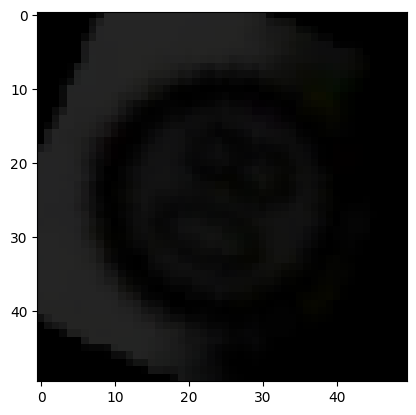

Label: tensor([38])


In [115]:
train_features, boxs, train_labels, shapes, colors = next(iter(training_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

### Modeling

In [96]:
from torchvision import models
import torch


# net = models.resnet18(weights=None)
# net.fc = torch.nn.Linear(net.fc.in_features, len(train_data.labels.info.class_names))

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [101]:
# for epoch in range(2):
#     running_loss = 0.0
#     for i, data in enumerate(training_loader):
#         images, labels = data['images'], data['labels']

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(images)
#         loss = criterion(outputs, labels.reshape(-1))
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                 (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0


Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 29.3k/1.91G [00:31<598:35:11, 950B/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 1.86M/1.91G [00:31<6:31:29, 87.1kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 3.70M/1.91G [00:32<2:49:03, 202kB/s] 
Please wait, filling up the shuffle buffer with samples.:   0%|          | 5.53M/1.91G [00:32<1:33:27, 364kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 7.36M/1.91G [00:33<1:01:32, 553kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 9.20M/1.91G [00:33<40:29, 839kB/s]  
Please wait, filling up the shuffle buffer with samples.:   1%|          | 11.0M/1.91G [00:34<30:29, 1.11MB/s]
Please wait, filling up the shuffle buffer with samples.:   1%|          | 12.9M/1.91G [00:34<21:27, 1.58MB/s]


Shuffle buffer filling is complete.
[1,   100] loss: 3.181
[1,   200] loss: 2.840
[1,   300] loss: 2.605
[1,   400] loss: 2.379



Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 29.3k/1.91G [00:05<96:21:39, 5.90kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 3.70M/1.91G [00:05<39:13, 869kB/s]    
Please wait, filling up the shuffle buffer with samples.:   0%|          | 7.36M/1.91G [00:06<20:42, 1.64MB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 9.20M/1.91G [00:06<15:15, 2.23MB/s]
Please wait, filling up the shuffle buffer with samples.:   1%|          | 11.0M/1.91G [00:07<14:10, 2.39MB/s]
Please wait, filling up the shuffle buffer with samples.:   1%|          | 12.9M/1.91G [00:07<11:09, 3.04MB/s]
Please wait, filling up the shuffle buffer with samples.:   1%|          | 14.7M/1.91G [00:08<10:59, 3.08MB/s]
Please wait, filling up the shuffle buffer with samples.:   1%|          | 16.5M/1.91G [00:08<09:02, 3.74MB/s]
Ple

Shuffle buffer filling is complete.
[2,   100] loss: 2.147
[2,   200] loss: 2.019
[2,   300] loss: 1.906
[2,   400] loss: 1.819


In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [112]:
len(training_loader)

429

In [17]:
class GTSRB_MODEL(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim


        self.metrics = {}

        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)


        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)


        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)


        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)


        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)


    def forward(self,input):

        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)


        flatten = self.flatten(maxpool)

        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)


        return output

    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc

    def validation_metrics(self,validation_data,loss_function):
       data_size = 11762
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() :
        for step,validation_ in enumerate(validation_data):
            input,label = validation_['images'].to(device),validation_['labels'].to(device)
            label = label.reshape(-1)

            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics


    def train_model(self,train_data,validation_data, device, epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = 27447
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step, train_ in enumerate(train_data):

                    input,label = train_['images'].to(device),train_['labels'].to(device)
                    labels = label.reshape(-1)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == labels).sum().item()
                    total_examples += labels.size(0)
                    l = loss_function(prediction,labels)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')


            learning_rate_scheduler.step()

        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')


In [18]:
import tqdm
EPOCHS = 10
LEARNING_RATE = 0.0008
INPUT_DIM = 3*50*50
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [19]:
model.train_model(train_data=training_loader,
                  validation_data=validation_loader,
                  device = device,
                  epochs=EPOCHS,
                  loss_function=loss,
                  optimizer=optimizer,
                  learning_rate_scheduler=lr_s)

training started ...


  0%|          | 0/27447 [00:00<?, ?it/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(

Please wait, filling up the shuffle buffer with samples.:   0%|          | 29.3k/1.91G [00:09<173:40:20, 3.28kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 1.86M/1.91G [00:11<2:29:02, 229kB/s]   
Please wait,

Shuffle buffer filling is complete.


Epoch [0/10], Step [428/27447], Learning Rate [0.0008], Loss [1.6079], Accuracy [0.3659]:   2%|▏         | 429/27447 [31:05<32:38:31,  4.35s/it]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
Please wait, filling up the shuffle buffer with samples.:  17%|█▋        | 337M/1.91G [00:16<01:17, 21.8MB/s]


Shuffle buffer filling is complete.
val_accuracy [0.19375956469988098], val_loss [4.388211727142334]


  0%|          | 0/27447 [00:00<?, ?it/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(

Please wait, filling up the shuffle buffer with samples.:   0%|          | 29.3k/1.91G [00:08<163:09:44, 3.49kB/s]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 1.86M/1.91G [00:10<2:20:37, 242kB/s]   
Please wait,

Shuffle buffer filling is complete.


Epoch [1/10], Step [428/27447], Learning Rate [0.00076], Loss [0.8721], Accuracy [0.6572]:   2%|▏         | 429/27447 [26:39<27:59:22,  3.73s/it]
Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(
Please wait, filling up the shuffle buffer with samples.:  17%|█▋        | 337M/1.91G [00:16<01:17, 21.8MB/s]


Shuffle buffer filling is complete.


KeyboardInterrupt: ignored

In [126]:
# saving a checkpoint assuming the network class named ClassNet
checkpoint = {'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epoch': EPOCHS}

torch.save(checkpoint, 'checkpoint.pkl')



In [ ]:
# # Loading model
# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = checkpoint['model']  # 提取网络结构
#     model.load_state_dict(checkpoint['model_state_dict'])  # 加载网络权重参数
#     optimizer = optimizer
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # 加载优化器参数

#     for parameter in model.parameters():
#         parameter.requires_grad = False
#     model.eval()

#     return model

# model = load_checkpoint('checkpoint.pkl')